# LSTMによる文書分類

In [3]:
import pandas as pd
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import re

import nltk
from nltk.tokenize import word_tokenize
import gensim.downloader
word2vec = gensim.downloader.load('word2vec-google-news-300')
# Download NLTK data (if not already done)
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

[nltk_data] Downloading package punkt to /Users/ryozawau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
def create_dataset(df,label):
    features = torch.tensor(df['embedding'].tolist(),dtype=torch.float32).to(device)
    labels = torch.tensor(df[label].values, dtype=torch.long).to(device)
    return TensorDataset(features, labels)

# Function for preprocessing text
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenization
    return tokens

def tokens_to_embedding(tokens, model, embedding_size=300):
    embeddings = [model[word] for word in tokens if word in model] # 単語リストのリストをループし、model[word]で各単語のベクトルを取得し、リストに格納
    # embeddingsが空の場合は、ゼロベクトルを返す
    if len(embeddings) == 0:
        return np.zeros(embedding_size)
    # embeddingsが空でない場合は、ベクトルの平均を返す。その結果は、ベクトルになる、センテンスの埋め込みとして使用できる
    else:
        return np.mean(embeddings, axis=0)

def tokenize_and_pad(text, max_len):
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens[:max_len] + ['<PAD>']*(max_len - len(tokens))
    return padded_tokens

def tokens_to_embedding_sequence(tokens, model, embedding_size=300):
    embedding_sequence = np.zeros((len(tokens), embedding_size))
    for i, token in enumerate(tokens):
        if token in model:
            embedding_sequence[i] = model[token]
        elif token == '<PAD>':
            embedding_sequence[i] = np.zeros(embedding_size)  # Zero vector for padding
    return embedding_sequence

In [42]:
max_sequence_length = 30  # You can choose an appropriate length

df=pd.read_csv("./Data/sentiment-emotion-labelled_Dell_tweets.csv")
df["sentiment"] = df["sentiment"].replace({"positive":2,"negative":0,"neutral":1})
df['processed_text'] = df['Text'].apply(preprocess_text)
#df["embedding"] = df["processed_text"].apply(lambda x: tokens_to_embedding(x, word2vec))
df['tokenized_text'] = df['Text'].apply(lambda x: tokenize_and_pad(x, max_sequence_length))
df['embedding'] = df['tokenized_text'].apply(lambda x: tokens_to_embedding_sequence(x, word2vec))


train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

batch_size = 32

train_dataset_sentiment = create_dataset(train_df,label="sentiment")
val_dataset_sentiment = create_dataset(val_df,label="sentiment")
test_dataset_sentiment = create_dataset(test_df,label="sentiment")

train_loader_sentiment  = DataLoader(train_dataset_sentiment, batch_size=batch_size, shuffle=True)
val_loader_sentiment  = DataLoader(val_dataset_sentiment, batch_size=batch_size)
test_loader_sentiment  = DataLoader(test_dataset_sentiment, batch_size=batch_size)

In [8]:
# DataLoaderから最初のバッチを取得
first_batch = next(iter(train_loader_sentiment))

# バッチの形状を表示
print(first_batch[0].shape)

torch.Size([32, 300])


In [43]:
class LSTMNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
    # Set initial hidden and cell states
    # Forward propagate LSTM
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [44]:
model = LSTMNN(300, 100, 4, 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [45]:
from sklearn.metrics import accuracy_score, f1_score

num_epochs = 50
best_f1_score = 0.0
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader_sentiment:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader_sentiment:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.numpy())
            val_labels.extend(labels.numpy())
    accuracy = accuracy_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds, average='weighted')

    print(f'Epoch {epoch+1}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

Epoch 1, Accuracy: 0.4131, F1 Score: 0.2415
Epoch 2, Accuracy: 0.4131, F1 Score: 0.2415
Epoch 3, Accuracy: 0.4131, F1 Score: 0.2415
Epoch 4, Accuracy: 0.4131, F1 Score: 0.2415


KeyboardInterrupt: 

In [17]:
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for inputs, labels in test_loader_sentiment:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.numpy())
        test_labels.extend(labels.numpy())

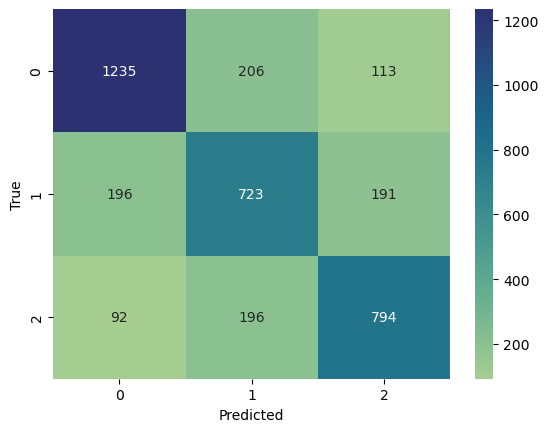

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="crest")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
# 訓練ループ
for epoch in range(10):
    for i, (tweets, labels) in enumerate(train_loader_sentiment):
        tweets = tweets.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(tweets)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 各エポックの終わりに損失を表示
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{10}], Loss: {loss.item():.4f}')    

Epoch [10/10], Loss: 0.3541
